### Install and import pandas library 

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

## 1. Reading and combining data

### Get CSV file paths 

In [3]:
file_paths = [
  'Wine_Stats/Australia_Wine_Stats.csv',
  'Wine_Stats/Chile_Wine_Stats.csv', 
  'Wine_Stats/France_Wine_Stats.csv',
  'Wine_Stats/Italy_Wine_Stats.csv',
  'Wine_Stats/New Zealand_Wine_Stats.csv',
  'Wine_Stats/Portugal_Wine_Stats.csv',
  'Wine_Stats/Spain_Wine_Stats.csv',
  'Wine_Stats/USA_Wine_Stats.csv'
]

### Load all CSV files into a list of DataFrames and set each column's data types.

In [4]:
df_list = [pd.read_csv(
  file, 
  sep = ',', 
  header = 0, 
  index_col = 0, 
  dtype = {
    'Name': str,
    'Rating': float,
    'Number of ratings': int,
    'Price': float,
    'Region': str,
    'Winery': str,
    'Wine style': str,
    'Alcohol content': float,
    'Grapes': str,
    'Food pairings': str,
    'Bold': float,
    'Tanin': float,
    'Sweet': float,
    'Acidic': float
  }) for file in file_paths]

### Concatenate all files into a one `wine_df` DataFrame

In [5]:
wine_df = pd.concat(df_list, ignore_index=True)

## 2. Initial data exploration and cleaning 

### Remove duplicate records from the `wine_df`

In [6]:
wine_df = wine_df.drop_duplicates()

### Remove records with null values in the 'Name' column

In [7]:
wine_df = wine_df[wine_df['Name'].notnull()]

## 3. Handle outliers and missing values 

### Remove outliers
We used the IQR(Interquartile Range) method to identify outliers in the data set. 
IQR method can be written in two main ways,
1. **Remove mild outliers**
   <br>Mild outliers are data point that's more extreme than the first quartile minus 1.5 times the interquartile range (IQR) or the third quartile plus 1.5 times the IQR.
2. **Remove extreme outliers**
   <br>Mild outliers are data point that's more extreme than the first quartile minus 3 times the interquartile range (IQR) or the third quartile plus 3 times the IQR.

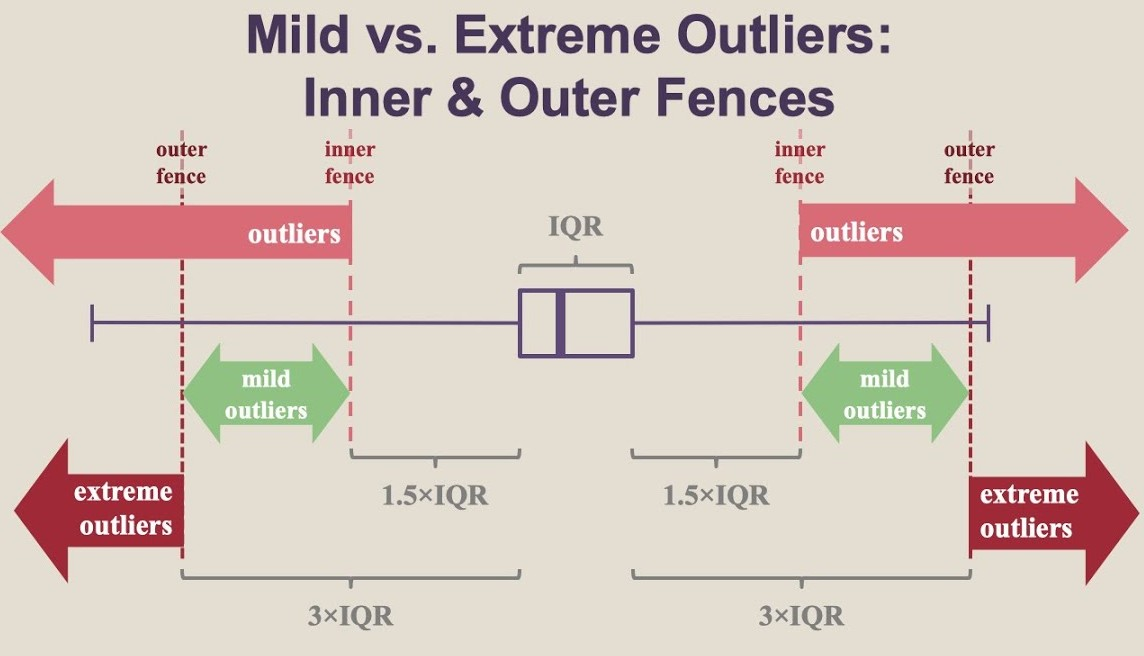

In [8]:
def remove_mild_outliers_iqr(df, column) :
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outlier_removed_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return outlier_removed_df

def remove_extreme_outliers_iqr(df, column) :
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 3 * IQR
  upper_bound = Q3 + 3 * IQR
  outlier_removed_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return outlier_removed_df

We decided to remove only extreme outliers. 
Reasons,
- Mild outliers might represent legitimate variations in the data. Removing them can lead to an unrealistic representation of the data distribution.
- Mild outliers can indicate true variability and diversity within the data. Retaining them helps in understanding the full range of the data and supports more robust and flexible models.
- Removing extreme outliers can improve model performance by reducing noise and potential overfitting. However, retaining mild outliers ensures that the model remains sensitive to less extreme but still significant variations, leading to better generalization on new, unseen data.
- Removing too many outliers can lead to underfitting, where the model is too simple to capture the underlying patterns.
- Keeping extreme outliers can lead to overfitting, where the model becomes too complex and sensitive to noise.

In [9]:
wine_df = remove_extreme_outliers_iqr(wine_df, 'Bold')
wine_df = remove_extreme_outliers_iqr(wine_df, 'Sweet')
wine_df = remove_extreme_outliers_iqr(wine_df, 'Acidic')

## 4. Adding new columns to the Dataframe

### 4.1 Add a new 'Country' column to the DataFrame
Country name extracted from the 'Region' column using string manioulation methods.
<br>Then strip the value to remove any leading and tailing whitespaces.

In [10]:
wine_df['Country'] = wine_df['Region'].str.split('/').str[0]
wine_df['Country'] = wine_df['Country'].str.strip()

### 4.2 Add a new 'Country_region' column to the DataFrame
Used the same string manipulation method as the above step.

In [11]:
wine_df['Country_region'] = wine_df['Region'].str.split('/').str[1]
wine_df['Country_region'] = wine_df['Country_region'].str.strip()

### 4.3 Create columns for each food pairing items 
Set value `True` if a particular wine has a food pairing with these new food pairing columns.
Unless the value should be `False`.

The `food_pairing` column is in a string format. <br> 
First we need to convert that string into an actual list. <br>
`cell.strip()` added to make sure this conversion process executes safely without getting to 'ValueErrors'. 

In [12]:
import ast

def convert_to_list(cell):
    if isinstance(cell, str):
        cell = cell.strip()
        return ast.literal_eval(cell)
    return cell

wine_df['Food pairings'] = wine_df['Food pairings'].apply(convert_to_list)

Get all food pairings into a python `Set`. <br>
`Set` type don't allow duplicate values. This feature of Sets makes things easy for us to get only distinct values while we can freely iterate over food pairings in each row.

In [13]:
all_food_pairings = set()
for food_pairing in wine_df['Food pairings']: 
    all_food_pairings.update(food_pairing)
print("Food pairing columns count: ", all_food_pairings.__len__())

Food pairing columns count:  21


Create columns for each food pairing from `all_food_pairings` set and set the default value to `False`.

In [14]:
for food_pairing in all_food_pairings :
  wine_df[food_pairing] = False

Then iterate over each row and set value to `True` if a particular food pairing is available in the `food pairing` column.

In [15]:
for index, row in wine_df.iterrows():
  matching_foods = row['Food pairings']
  for food in matching_foods:
    wine_df.at[index, food] = True

## 5. Coluumn Removal
We decided to remove following columns and reasons are given below,
1. **Food pairings** <br>
    In subtask 4.3, every possible food pairing is added to separate columns and marked them `True` if a particular wine has a certian food pairing, other non-relavant food pairing columns shows `False`. No need to of keeping this `Food pairing` columns now.
2. **Region** <br>
    In subtask 4.1, `Country` and the `Country_region` is extracted to separate columns. No need of keeping this `Region` column.
3. **Grapes** <br>
    Grapes column hugely contains empty cells. Due to this reason it was not in a good condition to use for any data visualization task. No point of keeping this column. 

In [16]:
wine_df.drop(columns=['Food pairings', 'Region', 'Grapes'], inplace=True)

### Additional
Extracting year from the name colunm, since we did our analysis based on the year. Which gave us null columns since non vintage wines doesn't have a exact manufacture date.

In [17]:
wine_df['Year'] = wine_df['Name'].str.extract(r'(\b\d{4}\b)')
wine_df['Year'] = pd.to_numeric(wine_df['Year'], errors='coerce')

wine_df['Year'] = wine_df['Year'].fillna('n.v.')

Export this DataFrame to a CSV file to use in later parts of the project.

In [18]:
wine_df.to_csv('wine.csv', index=False)